# Experimenting with new location

- this playbook contains the code for the experimentation with new location

In [2]:
import os
import csv
import pandas as pd

version = "v5"
dataset_path = f"../data/processed/"

# files
filename = f"{version}-2_stages-full_statistical_with_window.csv"
filename2 = f"{version}-2_stages-fourier_window_big.csv"
filename3 = f"{version}-2_stages-fourier_normalized_int_XYZ.csv"


# datasets
df_statistical = pd.read_csv(f"{dataset_path}/{filename}")
df_spectral = pd.read_csv(f"{dataset_path}/{filename2}")
df_spectral_normalized = pd.read_csv(f"{dataset_path}/{filename3}")

In [3]:
from lib import device_mapping, reverse_device_mapping

# ------------------------------------------------
# choice of dataset

# df = df_statistical
# df = df_spectral
df = df_spectral_normalized

# ------------------------------------------------
# choice of phone

# GooglePixel6:        03575768cc23b2df
# RedmiNote8PRO:       4aaf95a621ccf092
# SamsungGalaxyA51:    029a77f196804217
# SamsungGalaxyS6:     e08d976ac75c011e


# df = df[df['device_id'].isin(reverse_device_mapping(['RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6', 'RedmiNote8PRO']))]
df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyA51', 'SamsungGalaxyS6']))]

# ------------------------------------------------
# choice of locations to include TOOD

# number of cases per device
df['device_id'].value_counts()


pandas.core.series.Series

In [4]:
correlation = df.iloc[:, 6:].apply(lambda x: df['label'].corr(x, method="pearson")).abs().sort_values(ascending=False)
correlation

Z_1            0.401143
Z_2            0.334112
intensity_2    0.307311
Y_1            0.286751
Z_40           0.254424
                 ...   
X_44           0.003123
X_25           0.002661
X_46           0.000651
Y_4            0.000407
X_12           0.000249
Length: 199, dtype: float64

In [5]:
# feature selection. First k or all greater then some correlation
selection = correlation[:10].index
# selection = correlation[correlation > 0.05].index
df[selection]

,Z_1,Z_2,intensity_2,Y_1,Z_40,Z_41,Z_36,Z_28,Z_20,Z_33
0,5.638308,2.877935,2.983096,7.367321,0.129980,0.136108,0.131908,0.220503,0.409285,0.216529
1,4.990691,3.141740,3.418753,6.597929,0.118837,0.120129,0.121782,0.225848,0.388350,0.129727
2,4.533820,3.207650,3.745431,5.798009,0.128450,0.137018,0.129934,0.199826,0.382012,0.149183
3,3.968126,3.115833,3.894197,4.953773,0.114018,0.121788,0.125030,0.243123,0.381718,0.164103
4,3.375192,2.865751,3.853589,4.064490,0.120028,0.129110,0.134233,0.215264,0.376682,0.152259
...,...,...,...,...,...,...,...,...,...,...
25737,1.438913,0.831759,0.822474,0.945452,0.155286,0.151905,0.216126,0.538982,0.501394,0.275571
25738,1.433340,0.839757,0.831731,0.945178,0.154927,0.152489,0.216591,0.532501,0.484644,0.277506
25739,1.423364,0.887376,0.876241,0.977083,0.153445,0.153551,0.213201,0.552839,0.473916,0.272968
25740,1.423977,0.879475,0.868828,0.979360,0.152302,0.152873,0.215088,0.516261,0.424400,0.283146


In [6]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from lib import device_mapping

results = []
for location in list(df['location'].unique()):

    # test is one location, train the rest
    test = df[df['location'] == location]
    train = df[df['location'] != location]

    y_test = test['label'].to_numpy()
    X_test = test[selection].to_numpy()
    y_train = train['label'].to_numpy()
    X_train = train[selection].to_numpy()

    # SVM
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_svm = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)

    # RF
    clf = RandomForestClassifier(max_depth=3)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_rf = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)

    device_name = device_mapping[test['device_id'].iloc[0]]
    results_temp = [location, device_name, acc_svm, acc_rf]
    results.append(results_temp)
    print(results_temp)

results_all = pd.DataFrame(results, columns=['Location', 'Device', 'SVM', 'RF', ])
results_all

['Restaurant', 'SamsungGalaxyA51', 0.7393124065769806, 0.8382660687593423]
['DormRoom5', 'SamsungGalaxyA51', 0.8459701492537314, 0.5776119402985075]
['DormRoom1', 'SamsungGalaxyA51', 0.6478494623655914, 0.6176821983273596]
['DormRoom6', 'SamsungGalaxyA51', 0.9039497307001796, 0.822262118491921]
['Kitchen2', 'SamsungGalaxyS6', 0.9405539993775288, 0.8565203859321506]
['DormRoom3', 'SamsungGalaxyS6', 0.8984962406015038, 0.9523809523809523]


,Location,Device,SVM,RF
0,Restaurant,SamsungGalaxyA51,0.739312,0.838266
1,DormRoom5,SamsungGalaxyA51,0.845970,0.577612
2,DormRoom1,SamsungGalaxyA51,0.647849,0.617682
3,DormRoom6,SamsungGalaxyA51,0.903950,0.822262
4,Kitchen2,SamsungGalaxyS6,0.940554,0.856520
5,DormRoom3,SamsungGalaxyS6,0.898496,0.952381


In [7]:
results_all[['SVM', 'RF']].mean()

SVM    0.829355
RF     0.777454
dtype: float64

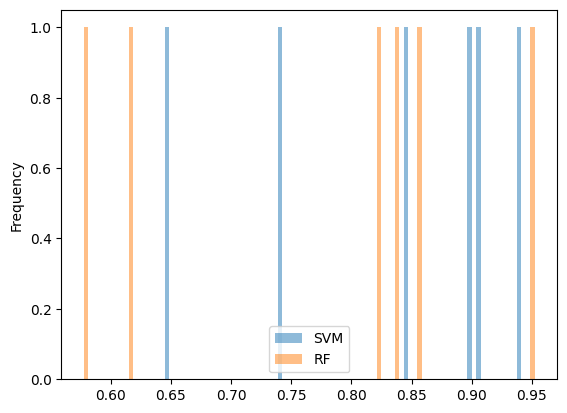

In [8]:
ax = results_all.plot.hist(bins=100, alpha=0.5)